In [2]:
## Create directory path
import os
dataset_path = '/Users/apple/tensorflow3/QBH/MIREX_05/Medley_db/'
song_path = []
for song_name in os.listdir(dataset_path) :
    if (song_name != '.DS_Store') : song_path.append(dataset_path + song_name + '/')
length = len(song_path)
song_path

['/Users/apple/tensorflow3/QBH/MIREX_05/Medley_db/AClassicEducation_NightOwl/']

In [3]:
## Create directories
wav_and_raw = [[[] for i in range(2)] for j in range(len(song_path))]
for i in range(len(song_path)) :
    for extension in os.listdir(song_path[i]) :
        if('wav' in extension) : wav_and_raw[i][0]=song_path[i]+extension
        elif('RAW' in extension) : wav_and_raw[i][1]=song_path[i]+extension
wav_and_raw[0][0]

'/Users/apple/tensorflow3/QBH/MIREX_05/Medley_db/AClassicEducation_NightOwl/AClassicEducation_NightOwl_MIX.wav'

In [4]:
## Read wavfile for a single song
import librosa
import IPython
song, sample_rate = librosa.load(wav_and_raw[0][0])
clipped_song = song[5*sample_rate: 25*sample_rate]
IPython.display.Audio(data = clipped_song, rate = sample_rate)
#sample_rate = 22050

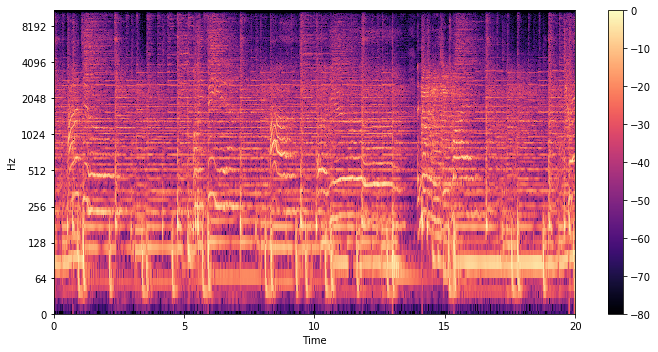

In [6]:
## Compute STFT
window_size = int(0.084*sample_rate)
hop_size = int(0.01*sample_rate)
Stft = librosa.stft(clipped_song, n_fft = window_size, hop_length=hop_size)
magnitude, phase = librosa.magphase(Stft)
# Plot
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10,5))
librosa.display.specshow(librosa.amplitude_to_db(magnitude,ref=np.max), x_axis='time', y_axis='log', 
                        sr=sample_rate, hop_length=hop_size)
plt.colorbar()
plt.tight_layout()

In [7]:
## PLCA
import numpy as np
F,T = magnitude.shape
Z = 5
Vft = magnitude
import random
random.seed(10)
Pt_z = np.random.uniform(low=0.0001, high=0.9999, size=(T,Z))
Pt_zbyf = np.random.uniform(low=0.0001, high=0.9999, size=(T,F,Z))
P_fbyz = np.random.uniform(low=0.0001, high=0.9999, size=(Z,F))

In [8]:
## Normalization rules
def normalize_Pt_z(T,Pt_z) :
    for t in range(T): 
        Pt_z[t,:] /= Pt_z[t,:]/sum(Pt_z[t,:])

def normalize_P_fbyz(Z,P_fbyz) :
    for z in range(Z): 
        P_fbyz[z,:] = P_fbyz[z,:]/sum(P_fbyz[z,:])

def normalize_Pt_zbyf(T,F,Pt_zbyf) :
    for t in range(T):
        for f in range(F):
            Pt_zbyf[t,f,:]=Pt_zbyf[t,f,:]/sum(Pt_zbyf[t,f,:])

In [9]:
## Normalize
normalize_Pt_z(T,Pt_z)
normalize_P_fbyz(Z,P_fbyz)
normalize_Pt_zbyf(T,F,Pt_zbyf)
P_fbyz

array([[6.29020951e-04, 4.45827372e-04, 1.91520313e-03, ...,
        1.71844092e-03, 6.53858147e-04, 4.41786593e-04],
       [2.39959224e-04, 1.29233372e-03, 8.23785733e-04, ...,
        2.37389535e-04, 7.25529656e-04, 1.40654118e-03],
       [1.69139905e-03, 1.70230803e-03, 4.35066780e-04, ...,
        1.37634238e-03, 6.37800348e-04, 1.31704459e-03],
       [1.76545951e-03, 1.93655608e-03, 8.02863864e-05, ...,
        1.84888317e-03, 1.51506586e-04, 1.88587955e-03],
       [1.44391820e-03, 1.98836852e-03, 1.40292158e-03, ...,
        8.35867826e-04, 1.84416327e-04, 7.30272396e-04]])

In [10]:
## Updation rules
def update_Pt_zbyf(T,Z,F,Pt_zbyf,Pt_z,P_fbyz) :
    for t in range(T):
        for f in range(F):
            for z in range(Z):
                Pt_zbyf[t,f,z] = Pt_z[t,z]*P_fbyz[z,f]/np.dot(Pt_z[t,:],P_fbyz[:,f])

def update_Pt_z(T,Z,Pt_z,Pt_zbyf,Vft) :
    for t in range(T):
        for z in range(Z):
            denominator=0
            for z1 in range(Z):
                if z1==z : numerator = np.dot(Vft[:,t], Pt_zbyf[t,:,z])
                denominator += np.dot(Vft[:,t], Pt_zbyf[t,:,z1])
            Pt_z[t,z] = numerator/denominator

def update_P_fbyz(Z,F,Pt_z,Pt_zbyf,Vft) :
    for z in range(Z):
        for f in range(F):
            denominator=0
            for f1 in range(F):
                if f1==f : numerator =  np.dot(Vft[f,:], Pt_zbyf[:,f,z])
                denominator += np.dot(Vft[f1,:], Pt_zbyf[:,f1,z])
            P_fbyz[z,f] = numerator/denominator

def update(max_iterations,T,Z,F,Vft,Pt_zbyf,Pt_z,P_fbyz) :
    for iteration in range(max_iterations) :
        update_Pt_zbyf(T,Z,F,Pt_zbyf,Pt_z,P_fbyz)
        update_Pt_z(T,Z,Pt_z,Pt_zbyf,Vft)
        update_P_fbyz(Z,F,Pt_z,Pt_zbyf,Vft)        

In [11]:
## Update
update(1,T,Z,F,Vft,Pt_zbyf,Pt_z,P_fbyz)
P_fbyz

array([[7.85595760e-05, 8.85939322e-05, 2.43593483e-03, ...,
        7.11576079e-07, 6.18503848e-07, 1.43380850e-07],
       [2.85303461e-05, 2.44482342e-04, 9.97471879e-04, ...,
        9.35801800e-08, 6.53355583e-07, 4.34576906e-07],
       [1.96200004e-04, 3.14191409e-04, 5.13955664e-04, ...,
        5.29336849e-07, 5.60354066e-07, 3.97006855e-07],
       [2.12270379e-04, 3.70480149e-04, 9.83083370e-05, ...,
        7.37044684e-07, 1.37971057e-07, 5.89237237e-07],
       [1.72086420e-04, 3.77054490e-04, 1.70276301e-03, ...,
        3.30289169e-07, 1.66467027e-07, 2.26169216e-07]])

In [16]:
## Reconstructed Spectrogram
Pft = np.matmul(P_fbyz.T, Pt_z.T)
Vft_reconstruct = Pft*Vft
Error = np.linalg.norm(Vft-Vft_reconstruct)
Error

5467.855615711113